# Colorbot


Special thanks to @MarkDaoust that helped us to improve the code.


![img](imgs/colorbot_model.png)
![img](imgs/colorbot_execution.png)


## Dependencies

In [1]:
# Tensorflow
import tensorflow as tf
print('Tested with TensorFLow 1.2.0')
print('Your TensorFlow version:', tf.__version__) 

# Feeding function for enqueue data
from tensorflow.python.estimator.inputs.queues import feeding_functions as ff

# Rnn common functions
from tensorflow.contrib.learn.python.learn.estimators import rnn_common

# Run an experiment
from tensorflow.contrib.learn.python.learn import learn_runner

# Model builder
from tensorflow.python.estimator import model_fn as model_fn_lib

# Plot images with pyplot
%matplotlib inline
from matplotlib import pyplot as plt

# Helpers for data processing
import pandas as pd
import numpy as np
import argparse

Tested with TensorFLow 1.2.0
Your TensorFlow version: 1.2.0


## Parameters

In [2]:
# Data files
TRAIN_INPUT = 'data/train.csv'
TEST_INPUT = 'data/test.csv'
MY_TEST_INPUT = 'data/mytest.csv'

# Parameters for training
STEPS = 10000
BATCH_SIZE = 64

# Parameters for data processing
CHARACTERS = [chr(i) for i in range(256)]
SEQUENCE_LENGTH_KEY = 'sequence_length'
COLOR_NAME_KEY = 'color_name'

## Helper functions

In [167]:
# Returns the column values from a CSV file as a list
def _get_csv_column(csv_file, column_name):
    with open(csv_file, 'r') as f:
        df = pd.read_csv(f)
        return df[column_name].tolist()

# Plot a color image
def _plot_rgb(rgb):
    data = [[rgb]]
    plt.figure(figsize=(2,2))
    plt.imshow(data, interpolation='nearest')
    plt.show()

## Input functions

In [248]:
def parse(line):
    # line: name, red, green, blue
    # split line
    items = tf.string_split([line],',')
    items = items.values
    
    # get color (r, g, b)
    color = tf.string_to_number(items[1:], out_type=tf.float32) / 255.0
    
    # split color_name into a sequence of characters
    color_name = tf.string_split([items[0]], '')
    length = color_name.indices[-1, 1] + 1 # length = index of last char + 1
    color_name = color_name.values
    
    return color, color_name, length

def length_bin(length):
    '''
    Chooses a bin for a word given it's length.
    The goal is to use group_by_window to group words
    with the ~ same ~ length in the same bin.
    
    Each bin will have the size of a batch, so it can train faster.
    '''
    bin_id = tf.cast(length / 5, dtype=tf.int64)
    return tf.minimum(bin_id, 10)

# Input function used for training and testing                                                
def get_input_fn(csv_file, batch_size, num_epochs=1, shuffle=True):
    def input_fn():
        dataset = (
            tf.contrib.data.TextLineDataset(csv_file) # reading from the HD
            .skip(1) # skip header
            .repeat(num_epochs) # repeat dataset the number of epochs
            .map(parse) # parse text to variables
            .group_by_window(key_func=lambda color, color_name, length: length_bin(length), # choose a bin
                             reduce_func=lambda key, ds: pad_batch(ds, batch_size), # 
                             window_size=batch_size) # size of each bin
        )
        
        # for our "manual" test we don't want to shuffle the data
        if shuffle:
            dataset = dataset.shuffle(buffer_size=100000) # shuffle

        # create iterator
        color, color_name, length = dataset.make_one_shot_iterator().get_next()

        features = {
            COLOR_NAME_KEY: color_name,
            SEQUENCE_LENGTH_KEY: length,
        }

        return features, color
    return input_fn
        
def pad_batch(ds, batch_size):
    return ds.padded_batch(batch_size, 
                           padded_shapes=([None], [None], []),
                           padding_values=(0.0, chr(0), tf.cast(0, tf.int64)))

In [249]:
train_input_fn = get_input_fn(TRAIN_INPUT, BATCH_SIZE)
test_input_fn = get_input_fn(TEST_INPUT, BATCH_SIZE)

## Creating the Estimator model

In [250]:
def get_model_fn(rnn_cell_sizes,
                 label_dimension,
                 dnn_layer_sizes=[],
                 optimizer='SGD',
                 learning_rate=0.01):
    
    def model_fn(features, labels, mode):
        
        color_name = features[COLOR_NAME_KEY]
        sequence_length = tf.cast(features[SEQUENCE_LENGTH_KEY], dtype=tf.int32) # int64 -> int32

        tf.Print(color_name, [color_name])
        
        # Creating a tf constant to hold the map char -> index
        # this is need to create the sparse tensor and after the one hot encode
        mapping = tf.constant(CHARACTERS, name="mapping")
        table = tf.contrib.lookup.index_table_from_tensor(mapping, dtype=tf.string)
        int_color_name = table.lookup(color_name)
        
        # representing colornames with one hot representation
        color_name_onehot = tf.one_hot(int_color_name, depth=len(CHARACTERS) + 1)
        
        # Each RNN layer will consist of a LSTM cell
        rnn_layers = [tf.contrib.rnn.LSTMCell(size) for size in rnn_cell_sizes]
        
        # Construct the layers
        multi_rnn_cell = tf.contrib.rnn.MultiRNNCell(rnn_layers)
        
        # Runs the RNN model dynamically
        # more about it at: 
        # https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn
        outputs, final_state = tf.nn.dynamic_rnn(cell=multi_rnn_cell,
                                                 inputs=color_name_onehot,
                                                 sequence_length=sequence_length,
                                                 dtype=tf.float32)

        # Slice to keep only the last cell of the RNN
        last_activations = rnn_common.select_last_activations(outputs,
                                                              sequence_length)

        # Construct dense layers on top of the last cell of the RNN
        for units in dnn_layer_sizes:
            last_activations = tf.layers.dense(
              last_activations, units, activation=tf.nn.relu)
        
        # Final dense layer for prediction
        predictions = tf.layers.dense(last_activations, label_dimension)

        loss = None
        train_op = None

        if mode != tf.contrib.learn.ModeKeys.INFER:    
            loss = tf.losses.mean_squared_error(labels, predictions)
    
        if mode == tf.contrib.learn.ModeKeys.TRAIN:    
            train_op = tf.contrib.layers.optimize_loss(
              loss,
              tf.contrib.framework.get_global_step(),
              optimizer=optimizer,
              learning_rate=learning_rate)
        
        return model_fn_lib.EstimatorSpec(mode,
                                           predictions=predictions,
                                           loss=loss,
                                           train_op=train_op)
    return model_fn

In [251]:
model_fn = get_model_fn(rnn_cell_sizes=[256, 128], # size of the hidden layers
                        label_dimension=3, # since is RGB
                        dnn_layer_sizes=[128], # size of units in the dense layers on top of the RNN
                        optimizer='Adam', #changing optimizer to Adam
                        learning_rate=0.01)

estimator = tf.estimator.Estimator(model_fn=model_fn, model_dir='/tmp/colorbot_model0')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_save_summary_steps': 100, '_tf_random_seed': 1, '_model_dir': '/tmp/colorbot_model0', '_session_config': None, '_save_checkpoints_steps': None}


## Trainning and Evaluating

We could use a [experiment](https://www.tensorflow.org/api_docs/python/tf/contrib/learn/Experiment) instead.


In [253]:
NUM_EPOCHS = 40
for i in range(NUM_EPOCHS):
    print('Training epoch %d' % i)
    print('-' * 20)
    estimator.train(input_fn=train_input_fn)
    print('Evaluating epoch %d' % i)
    print('-' * 20)
    estimator.evaluate(input_fn = test_input_fn)

Training epoch 0
--------------------


/usr/local/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/colorbot_model0/model.ckpt-1
INFO:tensorflow:Saving checkpoints for 2 into /tmp/colorbot_model0/model.ckpt.
INFO:tensorflow:step = 2, loss = 0.170063
INFO:tensorflow:Saving checkpoints for 24 into /tmp/colorbot_model0/model.ckpt.
INFO:tensorflow:Loss for final step: 0.07498.
Evaluating epoch 0
--------------------
INFO:tensorflow:Starting evaluation at 2017-06-27-23:45:30
INFO:tensorflow:Restoring parameters from /tmp/colorbot_model0/model.ckpt-24
INFO:tensorflow:Finished evaluation at 2017-06-27-23:45:30
INFO:tensorflow:Saving dict for global step 24: global_step = 24, loss = 0.141949
Training epoch 1
--------------------
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/colorbot_model0/model.ckpt-24
INFO:tensorflow:Saving checkpoints for 25 into /tmp/colorbot_model0/model.ckpt.
INFO:tensorflow:step = 25, loss = 0.120725
INFO:tensorflow:Saving checkpoints

INFO:tensorflow:step = 255, loss = 0.0979197
INFO:tensorflow:Saving checkpoints for 277 into /tmp/colorbot_model0/model.ckpt.
INFO:tensorflow:Loss for final step: 0.033256.
Evaluating epoch 11
--------------------
INFO:tensorflow:Starting evaluation at 2017-06-27-23:46:06
INFO:tensorflow:Restoring parameters from /tmp/colorbot_model0/model.ckpt-277
INFO:tensorflow:Finished evaluation at 2017-06-27-23:46:06
INFO:tensorflow:Saving dict for global step 277: global_step = 277, loss = 0.0635819
Training epoch 12
--------------------
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/colorbot_model0/model.ckpt-277
INFO:tensorflow:Saving checkpoints for 278 into /tmp/colorbot_model0/model.ckpt.
INFO:tensorflow:step = 278, loss = 0.0850285
INFO:tensorflow:Saving checkpoints for 300 into /tmp/colorbot_model0/model.ckpt.
INFO:tensorflow:Loss for final step: 0.0218671.
Evaluating epoch 12
--------------------
INFO:tensorflow:Starting evaluation at 2017-06-2

INFO:tensorflow:Loss for final step: 0.0134246.
Evaluating epoch 22
--------------------
INFO:tensorflow:Starting evaluation at 2017-06-27-23:46:39
INFO:tensorflow:Restoring parameters from /tmp/colorbot_model0/model.ckpt-530
INFO:tensorflow:Finished evaluation at 2017-06-27-23:46:39
INFO:tensorflow:Saving dict for global step 530: global_step = 530, loss = 0.0649178
Training epoch 23
--------------------
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/colorbot_model0/model.ckpt-530
INFO:tensorflow:Saving checkpoints for 531 into /tmp/colorbot_model0/model.ckpt.
INFO:tensorflow:step = 531, loss = 0.0637433
INFO:tensorflow:Saving checkpoints for 553 into /tmp/colorbot_model0/model.ckpt.
INFO:tensorflow:Loss for final step: 0.0304333.
Evaluating epoch 23
--------------------
INFO:tensorflow:Starting evaluation at 2017-06-27-23:46:42
INFO:tensorflow:Restoring parameters from /tmp/colorbot_model0/model.ckpt-553
INFO:tensorflow:Finished evaluation 

INFO:tensorflow:Starting evaluation at 2017-06-27-23:47:11
INFO:tensorflow:Restoring parameters from /tmp/colorbot_model0/model.ckpt-783
INFO:tensorflow:Finished evaluation at 2017-06-27-23:47:11
INFO:tensorflow:Saving dict for global step 783: global_step = 783, loss = 0.0600659
Training epoch 34
--------------------
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/colorbot_model0/model.ckpt-783
INFO:tensorflow:Saving checkpoints for 784 into /tmp/colorbot_model0/model.ckpt.
INFO:tensorflow:step = 784, loss = 0.0409319
INFO:tensorflow:Saving checkpoints for 806 into /tmp/colorbot_model0/model.ckpt.
INFO:tensorflow:Loss for final step: 0.00749955.
Evaluating epoch 34
--------------------
INFO:tensorflow:Starting evaluation at 2017-06-27-23:47:14
INFO:tensorflow:Restoring parameters from /tmp/colorbot_model0/model.ckpt-806
INFO:tensorflow:Finished evaluation at 2017-06-27-23:47:14
INFO:tensorflow:Saving dict for global step 806: global_step = 80

## Making Predictions


INFO:tensorflow:Restoring parameters from /tmp/colorbot_model0/model.ckpt-921
orange, rgb: (235, 114, 28)


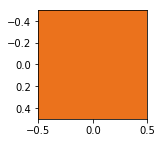

tensorflow orange, rgb: (249, 116, 29)


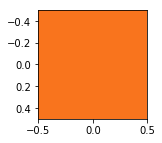

adfgasdgasd, rgb: (186, 72, 43)


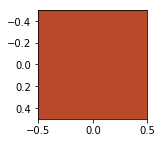

purple blue, rgb: (17, 77, 221)


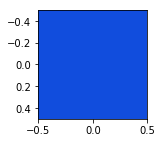

purple red, rgb: (182, 24, 49)


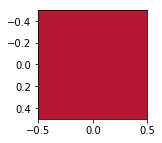

purple, rgb: (135, 39, 190)


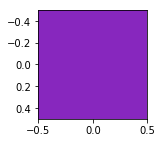

water, rgb: (252, 114, 192)


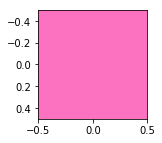

pink, rgb: (232, 143, 208)


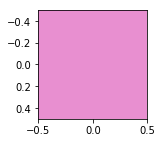

rock, rgb: (132, 145, 79)


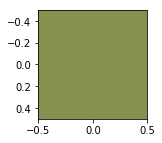

In [256]:
def predict(estimator, input_file):
    preds = estimator.predict(input_fn=get_input_fn(input_file, 1, shuffle=False))

    color_names = _get_csv_column(input_file, 'name')

    print()
    for p, name in zip(preds, color_names):
        color = tuple(map(int, p * 255))
        print(name + ',', 'rgb:', color)
        _plot_rgb(p)
    
predict(estimator, MY_TEST_INPUT)

## Pre-trained model predictions

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_save_summary_steps': 100, '_tf_random_seed': 1, '_model_dir': 'pretrained', '_session_config': None, '_save_checkpoints_steps': None}

INFO:tensorflow:Restoring parameters from pretrained/model.ckpt-10020
orange, rgb: (249, 89, 4)


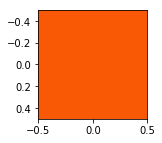

tensorflow orange, rgb: (243, 99, 40)


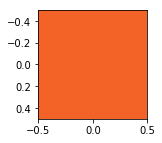

adfgasdgasd, rgb: (172, 152, 103)


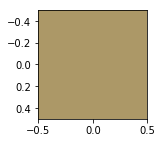

purple blue, rgb: (56, 50, 214)


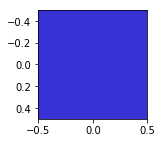

purple red, rgb: (168, 20, 69)


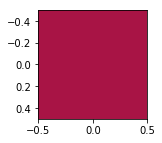

purple, rgb: (133, 49, 193)


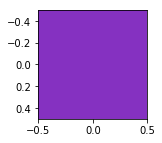

water, rgb: (148, 218, 240)


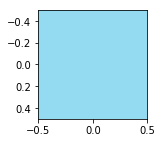

pink, rgb: (247, 123, 182)


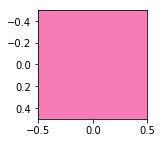

rock, rgb: (111, 46, 57)


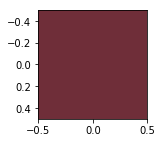

In [257]:
pre_estimator = tf.estimator.Estimator(model_dir='pretrained', model_fn=model_fn)
predict(pre_estimator, MY_TEST_INPUT)

In [180]:
'''features, label = get_input_fn(TEST_INPUT, 1, shuffle=False)()

with tf.Session() as sess:
    items = sess.run(features)
    print(items[COLOR_NAME_KEY])
    print(items[SEQUENCE_LENGTH_KEY])
    print
    
    labels = sess.run(label)
    print(labels)

    items = sess.run(features)
    print(items[COLOR_NAME_KEY])
    print(items[SEQUENCE_LENGTH_KEY])
    print
    
    labels = sess.run(label)
    print(labels)
    '''

[[b't' b'a' b'n' b'g' b'e' b'l' b'o']]
[7]
[[ 0.36470589  0.16862746  0.17254902]]
[[b'u' b'n' b'i' b'v' b'e' b'r' b's' b'i' b't' b'y' b' ' b'o' b'f' b' '
  b'c' b'a' b'l' b'i' b'f' b'o' b'r' b'n' b'i' b'a' b' ' b'g' b'o' b'l'
  b'd']]
[29]
[[ 0.78823531  0.75294119  0.73333335]]
